In [1]:
from model import UNet
import torch


In [2]:
def get_device():
    """Get the device to use for PyTorch operations (CPU or cuda or MPS)."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS (Apple Silicon)")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

device = get_device()

Using CUDA


In [4]:
model = UNet(
    in_channels=1,
    out_channels=1
).to(device)


In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

common_transforms = A.Compose([
    A.ShiftScaleRotate(p=0.2),
    A.RandomCrop(height=512, width=512),
    A.HorizontalFlip(p=0.5),
    # ToTensorV2()

])

# Not for mask
image_transforms = A.Compose([
    A.RandomBrightnessContrast(p=0.2),  # Solo per l'immagine
    ToTensorV2()
])

c:\Users\lgand\anaconda3\envs\DL\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
c:\Users\lgand\anaconda3\envs\DL\Lib\site-packages\albumentations\core\validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [7]:
from datamodule import BinarySegmentationDataset

ds = BinarySegmentationDataset(
    images_dir='../output_blob/stretched/',
    masks_dir='../output_blob/masks_man/',
    common_transform= common_transforms,
    image_transform= image_transforms,
    mask_divisor=True
)

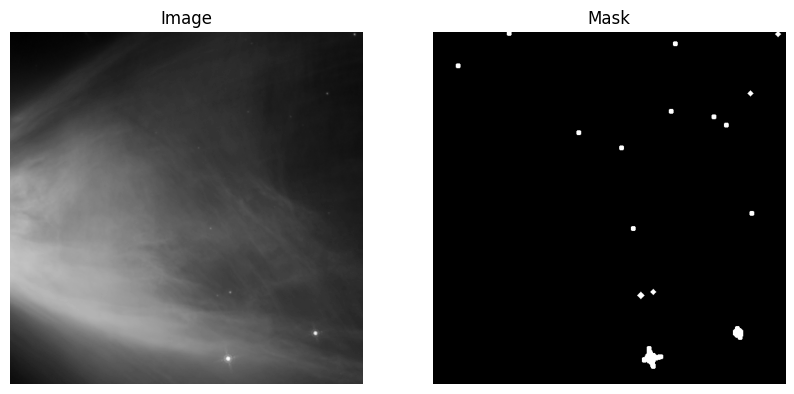

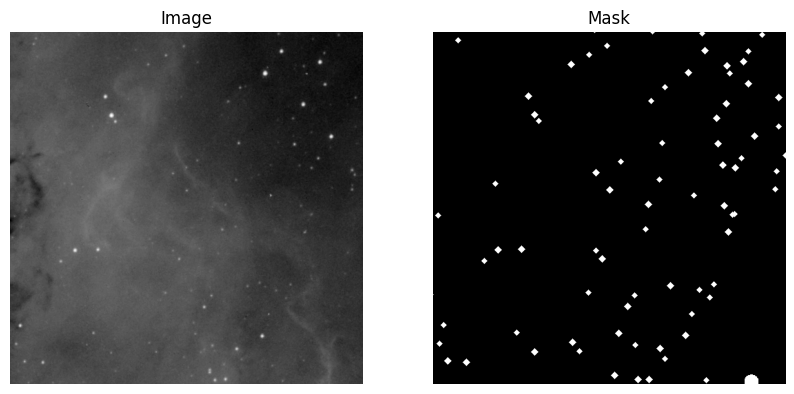

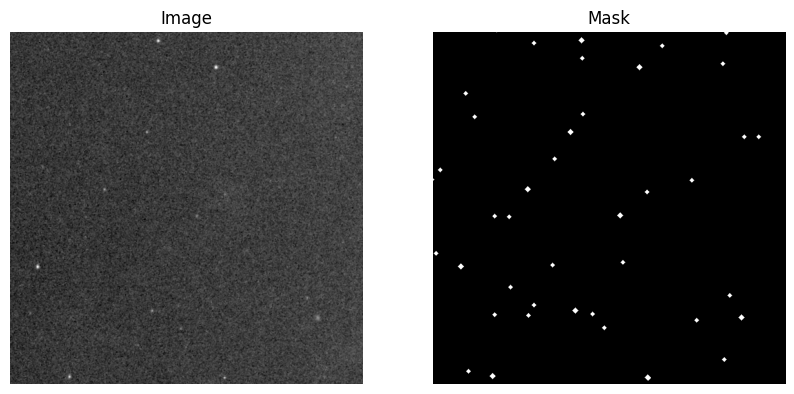

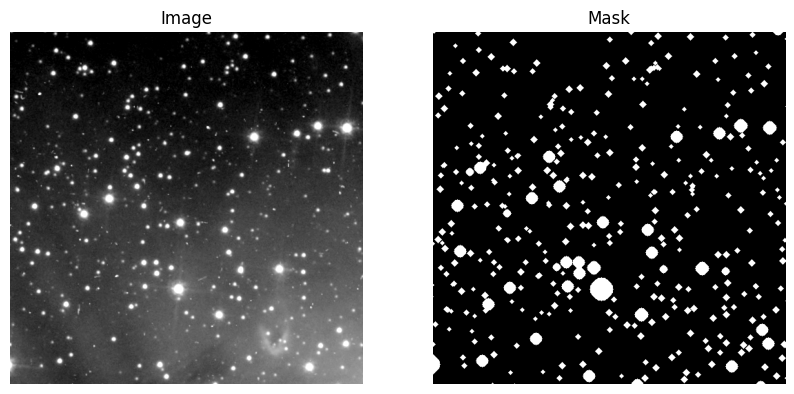

In [8]:
import matplotlib.pyplot as plt
for im, mask in ds:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(im.permute(1, 2, 0).squeeze().numpy(), cmap='gray')
    axs[0].set_title('Image')
    axs[1].imshow(mask.squeeze().numpy(), cmap='gray')
    axs[1].set_title('Mask')
    for ax in axs:
        ax.axis('off')
    plt.show()
    

In [13]:
from datamodule import BinarySegmentationDataModule
dm = BinarySegmentationDataModule(
    train_images_dir='../output_blob/stretched/',
    train_masks_dir='../output_blob/masks_man/',
    val_images_dir='../output_blob/stretched/',
    val_masks_dir='../output_blob/masks_man/',

    transforms= {"train_common": common_transforms,
                 "train_image": image_transforms,
                 "val_common": common_transforms,
                 "val_image": image_transforms},
    img_size=(512, 512),
    batch_size=2,
    num_workers=0,      # SE aumento il numero di workers, va molto più lento
    mask_divisor=True,
)
dm.setup()
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

In [20]:
for images, masks in train_loader:
    print(images.shape)  
    print(masks.shape)   
    break
    

torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])


In [21]:
model = UNet(
    in_channels=1,
    out_channels=1
).to(device)


In [22]:
import torch.nn as nn
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(50).to(device))  # Adjust pos_weight as needed
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 30

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/30], Loss: 2.8546
Epoch [2/30], Loss: 3.3524
Epoch [3/30], Loss: 1.5210
Epoch [4/30], Loss: 1.9289
Epoch [5/30], Loss: 1.9473
Epoch [6/30], Loss: 1.8768
Epoch [7/30], Loss: 1.8839
Epoch [8/30], Loss: 1.7216
Epoch [9/30], Loss: 1.6752
Epoch [10/30], Loss: 1.7333
Epoch [11/30], Loss: 1.7174
Epoch [12/30], Loss: 1.3222
Epoch [13/30], Loss: 1.6870
Epoch [14/30], Loss: 1.5898
Epoch [15/30], Loss: 1.6276
Epoch [16/30], Loss: 1.3810
Epoch [17/30], Loss: 1.6496
Epoch [18/30], Loss: 1.6693
Epoch [19/30], Loss: 1.4871
Epoch [20/30], Loss: 1.6659
Epoch [21/30], Loss: 1.4860
Epoch [22/30], Loss: 1.6263
Epoch [23/30], Loss: 1.1720
Epoch [24/30], Loss: 1.7313
Epoch [25/30], Loss: 2.0569
Epoch [26/30], Loss: 1.1452
Epoch [27/30], Loss: 1.7002
Epoch [28/30], Loss: 1.4688
Epoch [29/30], Loss: 1.3936
Epoch [30/30], Loss: 1.2504


In [31]:
import torch.nn as nn
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(30).to(device))  # Adjust pos_weight as needed
optimizer = optim.Adam(model.parameters(), lr=2e-5)

num_epochs = 30

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/30], Loss: 1.1494
Epoch [2/30], Loss: 0.9587
Epoch [3/30], Loss: 0.9088
Epoch [4/30], Loss: 1.0527
Epoch [5/30], Loss: 1.2640
Epoch [6/30], Loss: 1.3335
Epoch [7/30], Loss: 1.0817
Epoch [8/30], Loss: 1.1115
Epoch [9/30], Loss: 1.1968
Epoch [10/30], Loss: 1.2793
Epoch [11/30], Loss: 1.1668
Epoch [12/30], Loss: 1.3737
Epoch [13/30], Loss: 1.2027
Epoch [14/30], Loss: 1.1283
Epoch [15/30], Loss: 1.1150
Epoch [16/30], Loss: 1.5179
Epoch [17/30], Loss: 1.3309
Epoch [18/30], Loss: 1.0244
Epoch [19/30], Loss: 1.0257
Epoch [20/30], Loss: 1.0210
Epoch [21/30], Loss: 1.2061
Epoch [22/30], Loss: 1.0787
Epoch [23/30], Loss: 1.0935
Epoch [24/30], Loss: 0.9364
Epoch [25/30], Loss: 1.0520
Epoch [26/30], Loss: 1.1372
Epoch [27/30], Loss: 1.0089
Epoch [28/30], Loss: 1.4646
Epoch [29/30], Loss: 0.9325
Epoch [30/30], Loss: 1.5390


In [32]:
import torch.nn as nn
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(10).to(device))  # Adjust pos_weight as needed
optimizer = optim.Adam(model.parameters(), lr=1e-5)

num_epochs = 30

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/30], Loss: 0.9073
Epoch [2/30], Loss: 0.7508
Epoch [3/30], Loss: 0.7573
Epoch [4/30], Loss: 0.7906
Epoch [5/30], Loss: 0.7928
Epoch [6/30], Loss: 0.8196
Epoch [7/30], Loss: 0.6595
Epoch [8/30], Loss: 0.7052
Epoch [9/30], Loss: 0.7022
Epoch [10/30], Loss: 0.7152
Epoch [11/30], Loss: 0.7343
Epoch [12/30], Loss: 0.6949
Epoch [13/30], Loss: 0.6786
Epoch [14/30], Loss: 0.7263
Epoch [15/30], Loss: 0.9771
Epoch [16/30], Loss: 0.7080
Epoch [17/30], Loss: 0.7313
Epoch [18/30], Loss: 0.9220
Epoch [19/30], Loss: 0.7207
Epoch [20/30], Loss: 0.6876
Epoch [21/30], Loss: 0.6449
Epoch [22/30], Loss: 0.6853
Epoch [23/30], Loss: 0.5667
Epoch [24/30], Loss: 0.6455
Epoch [25/30], Loss: 0.9150
Epoch [26/30], Loss: 0.7359
Epoch [27/30], Loss: 0.6138
Epoch [28/30], Loss: 0.9012
Epoch [29/30], Loss: 0.6454
Epoch [30/30], Loss: 0.9133


In [44]:
import torch.nn as nn
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(30).to(device))  # Adjust pos_weight as needed
optimizer = optim.Adam(model.parameters(), lr=1e-5)

num_epochs = 15

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/15], Loss: 6.5888
Epoch [2/15], Loss: 1.7401
Epoch [3/15], Loss: 1.5946
Epoch [4/15], Loss: 0.7135
Epoch [5/15], Loss: 1.5041
Epoch [6/15], Loss: 0.7572
Epoch [7/15], Loss: 3.0471
Epoch [8/15], Loss: 1.1452
Epoch [9/15], Loss: 1.3406
Epoch [10/15], Loss: 0.8614
Epoch [11/15], Loss: 1.2275
Epoch [12/15], Loss: 0.9498
Epoch [13/15], Loss: 1.0945
Epoch [14/15], Loss: 1.2063
Epoch [15/15], Loss: 1.2454


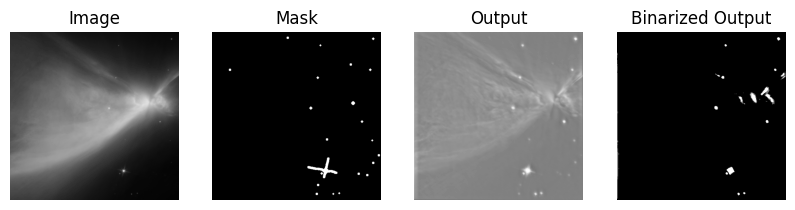

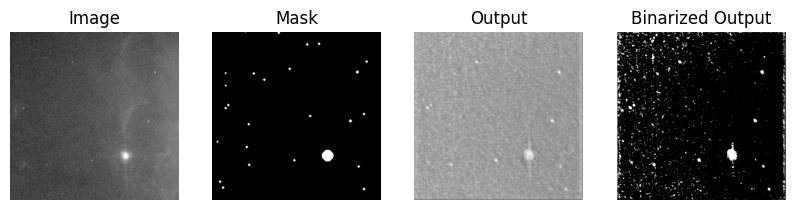

In [47]:
model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        outputs = model(images)
        images = images / 255
        # outputs = outputs.squeeze(1)  # [B, 1, H, W] -> [B, H, W] if needed

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(images[0].cpu().permute(1, 2, 0).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
        plt.title('Image')
        plt.axis('off')
        plt.subplot(1, 4, 2)
        plt.imshow(masks[0].cpu().squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(1, 4, 3)
        outputs = torch.sigmoid(outputs)
        plt.imshow(outputs[0].cpu().squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
        plt.title('Output')
        plt.axis('off')
        # binarize the output
        outputs = (outputs > 0.7).float()
        plt.subplot(1, 4, 4)
        plt.imshow(outputs[0].cpu().squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
        plt.title('Binarized Output')
        plt.axis('off')

In [31]:
# save model
torch.save(model.state_dict(), 'checkpoints/seg_0.pth')

In [11]:
from model import UNet
import torch
model = UNet(
    in_channels=1,
    out_channels=1
)
model.load_state_dict(torch.load("checkpoints/seg__gen_1.pth"))
model = model.to(device)
model.eval()

C:\Users\lgand\AppData\Local\Temp\ipykernel_16988\1974319688.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoints/seg__gen_1.pth

UNet(
  (down1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down3): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (

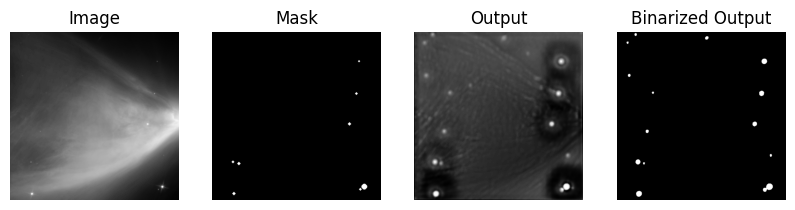

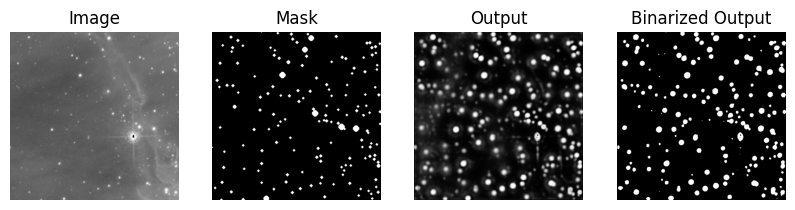

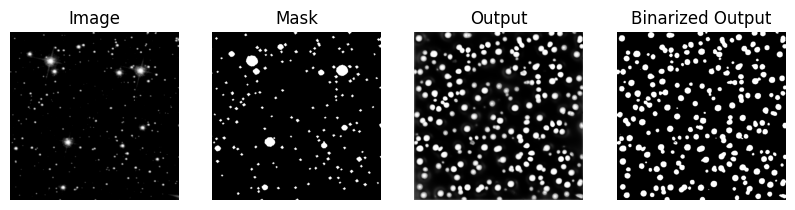

In [15]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        outputs = model(images)
        # outputs = outputs.squeeze(1)  # [B, 1, H, W] -> [B, H, W] if needed

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(images[0].cpu().permute(1, 2, 0).squeeze().numpy(), cmap='gray')
        plt.title('Image')
        plt.axis('off')
        plt.subplot(1, 4, 2)
        plt.imshow(masks[0].cpu().squeeze().numpy(), cmap='gray')
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(1, 4, 3)
        outputs = torch.sigmoid(outputs)
        plt.imshow(outputs[0].cpu().squeeze().numpy(), cmap='gray')
        plt.title('Output')
        plt.axis('off')
        # binarize the output
        outputs = (outputs > 0.5).float()
        plt.subplot(1, 4, 4)
        plt.imshow(outputs[0].cpu().squeeze().numpy(), cmap='gray')
        plt.title('Binarized Output')
        plt.axis('off')